In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hockey_rink import NHLRink
from scipy.stats import binned_statistic, binned_statistic_2d
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import matplotlib as mpl
import matplotlib.lines as lines


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df_games = pd.read_csv('data/df_Linhac_games_with_xT.csv')
df_move = pd.read_csv('data/df_Linahc_move_with_xT.csv')

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [4]:
x_entry =  25.42857143
y1_entry = -42.5
y2_entry =  42.5

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False
    
l1 = line([x_entry,y1_entry],[x_entry,y2_entry])

In [5]:
# The concept of entry sequences is adopted from the work of David Sumpter and and Aleksander Andrzejewski on Possession Chains (https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html). We do not take any credit for these sequences 

In [6]:
df_games.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg_allattempts,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal,next_event,interruption,next_teamid,next_teaminpossession,prev_event,xadjcoord_end,yadjcoord_end,xT_off,xT_def,xT
0,72393,553243.0,885,489917,172367.0,814,NaN,NaN,NaN,0.000000,faceoff_lost,1,evenStrength,5,failed,1,F,0,5,none,0.304306,0.251442,0,0,0.0,0.0,0.0,0.0,0.0,0.0,faceoff,0,885,NaN,start,NaN,NaN,NaN,NaN,NaN
1,72393,172367.0,814,435025,553243.0,885,NaN,NaN,NaN,0.000000,faceoff,0,evenStrength,5,successful,1,F,0,5,recovered,-0.304306,-0.251442,1,1,0.0,0.0,0.0,0.0,0.0,0.0,lpr,0,885,885.0,faceoff_lost,0.205826,0.245975,NaN,NaN,NaN
2,72393,172367.0,814,435025,553243.0,885,885.0,0.0,NaN,1.333333,lpr,0,evenStrength,5,successful,1,F,0,5,faceoffcontested,0.205826,0.245975,2,1,0.0,0.0,0.0,0.0,0.0,0.0,lpr,0,814,885.0,faceoff,0.205826,0.245975,0.000000,0.000000,0.000000
3,72393,553243.0,885,489917,172367.0,814,885.0,0.0,NaN,1.333333,lpr,1,evenStrength,5,failed,1,F,0,5,contested,-0.205826,-0.245975,3,0,0.0,0.0,0.0,0.0,0.0,0.0,pass,0,885,885.0,lpr,-3.223473,-3.766563,-0.000003,-0.000327,-0.000330
4,72393,172367.0,814,435025,553243.0,885,885.0,0.0,NaN,2.166667,pass,0,evenStrength,5,successful,1,F,0,5,south,3.223473,3.766563,4,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,885,885.0,lpr,-19.911827,11.310680,-0.000324,-0.000024,-0.000348


In [7]:
chain_team = df_games.iloc[0]["teaminpossession"]
period = df_games.iloc[0]["period"]
stop_criterion = 0
chain = 0
flag = 0
df_games["entry_seq"] = 0
df_games["entry_seq_team"] = 0
df_games['entry_in_seq'] = 0
for i, row in df_games.iterrows():
        df_games.at[i, "entry_seq"] = chain
        df_games.at[i, "entry_seq_team"] = chain_team
        if(flag == 1):
            df_games.at[i-1, "xadjcoord_end"] = row['xadjcoord']
            df_games.at[i-1, "yadjcoord_end"] = row['yadjcoord']
            flag = 0
            
        if (row['eventname'] == 'controlledentry') & (row['teamid'] == chain_team):
                stop_criterion += 2
                flag = 1

        if (row['eventname']== 'pass') & (row['outcome_code'] == 0):
                stop_criterion += 1
        
        if (row['teaminpossession'] != chain_team):
                stop_criterion += 1

        if row['period'] != period:
                chain += 1
                stop_criterion = 0
                period = row["period"]
                df_games.at[i, "entry_seq"] = chain
        
        if row["eventname"] == 'shot':
                if row['next_event'] in ['goal', 'save', 'block']:
                        stop_criterion += 1
                else:
                        stop_criterion += 2

        if row["eventname"] in ['goal', 'save', 'block']:
                if row['prev_event'] == 'shot':
                        stop_criterion += 1

        if row["eventname"] in ["offside", 'icing']:
                stop_criterion += 2
        if row['next_event'] == 'faceoff':
                if row['eventname'] not in ['faceoff', 'start', 'goal', 'save', 'block', 'shot']:
                        stop_criterion += 2

        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['next_teaminpossession']

In [8]:
df_passes = df_move[(df_move.eventname == 'pass')].copy()
df_carry = df_move[(df_move.eventname == 'carry')].copy()
df_move_entry = pd.concat([df_passes, df_carry], axis=0)

In [9]:
entry_sequences = df_games['entry_seq'].unique()
len(entry_sequences)

100857

In [10]:
df_games_entry = df_games[df_games.eventname.isin(['pass', 'carry', 'controlledentry'])].copy()
df_games_entry = df_games_entry[(df_games_entry['xadjcoord'] < 0) | (df_games_entry['eventname'] == 'controlledentry')].copy()

In [11]:
df_pre_entry = df_games_entry[((df_games_entry['eventname'].shift(1) == "controlledentry") & (df_games_entry['outcome'] == 'successful'))
                   |((df_games_entry['eventname'] == "controlledentry") & (df_games_entry['outcome'] == 'successful'))
                   | ((df_games_entry['eventname'].shift(-1) == "controlledentry") & (df_games_entry['outcome'].shift(-1) == 'successful'))
                   | ((df_games_entry['eventname'].shift(-2) == "controlledentry") & (df_games_entry['outcome'].shift(-2) == 'successful'))
                   | ((df_games_entry['eventname'].shift(-3) == "controlledentry") & (df_games_entry['outcome'].shift(-3) == 'successful'))
                   ]
# drop unsuccessful entries
print(df_pre_entry.shape)
df_pre_entry = df_pre_entry[(df_pre_entry['eventname'] != "controlledexit") | (df_pre_entry['outcome'] == 'successful')]
df_pre_entry.shape

(50090, 43)


(50090, 43)

In [12]:
df_pre_entry['entry_intersection'] = df_pre_entry.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_pre_entry['x_exit'] = df_pre_entry['entry_intersection'].str[0]
df_pre_entry['y_exit'] = df_pre_entry['entry_intersection'].str[1]

In [13]:
df_pre_entry["entry_lane_int"] = pd.cut(df_pre_entry['y_exit'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [14]:
df_pre_entry["entry_lane_int"].value_counts()

entry_lane_int
4.0    8624
0.0    8173
3.0    4485
2.0    4370
1.0    4346
Name: count, dtype: int64

In [15]:
df_pre_entry.loc[df_pre_entry['eventname'] == "controlledentry", "entry_lane"] = pd.cut(df_pre_entry.loc[df_pre_entry['eventname'] == "controlledentry", "yadjcoord"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [16]:
entry_lanes = {
    4: "left",
    3: "middle left",
    2: "middle",
    1: "middle right",
    0: "right"
}

In [17]:
df_pre_entry['entry_lane_name'] = df_pre_entry['entry_lane'].map(entry_lanes)
df_pre_entry['entry_lane_name_int'] = df_pre_entry['entry_lane_int'].map(entry_lanes)

In [18]:
df_pre_entry.loc[df_pre_entry['eventname'] == "controlledentry", "entry_lane"].value_counts()

entry_lane
4.0    4131
0.0    3809
3.0    1427
2.0    1385
1.0    1380
Name: count, dtype: int64

In [19]:
df_pre_entry.loc[df_pre_entry['eventname'] == "controlledentry", "entry_lane_int"] = df_pre_entry.loc[df_pre_entry['eventname'].shift(-1) == "controlledentry", 'entry_lane_int'].values

In [20]:
df_pre_entry.loc[df_pre_entry['eventname'] == "controlledentry", "entry_lane_int"].value_counts()

entry_lane_int
4.0    2576
0.0    2404
3.0    1471
2.0    1443
1.0    1400
Name: count, dtype: int64

In [21]:
df_pre_entry['entry_lane_name_int'].value_counts()

entry_lane_name_int
left            8624
right           8173
middle left     4485
middle          4370
middle right    4346
Name: count, dtype: int64

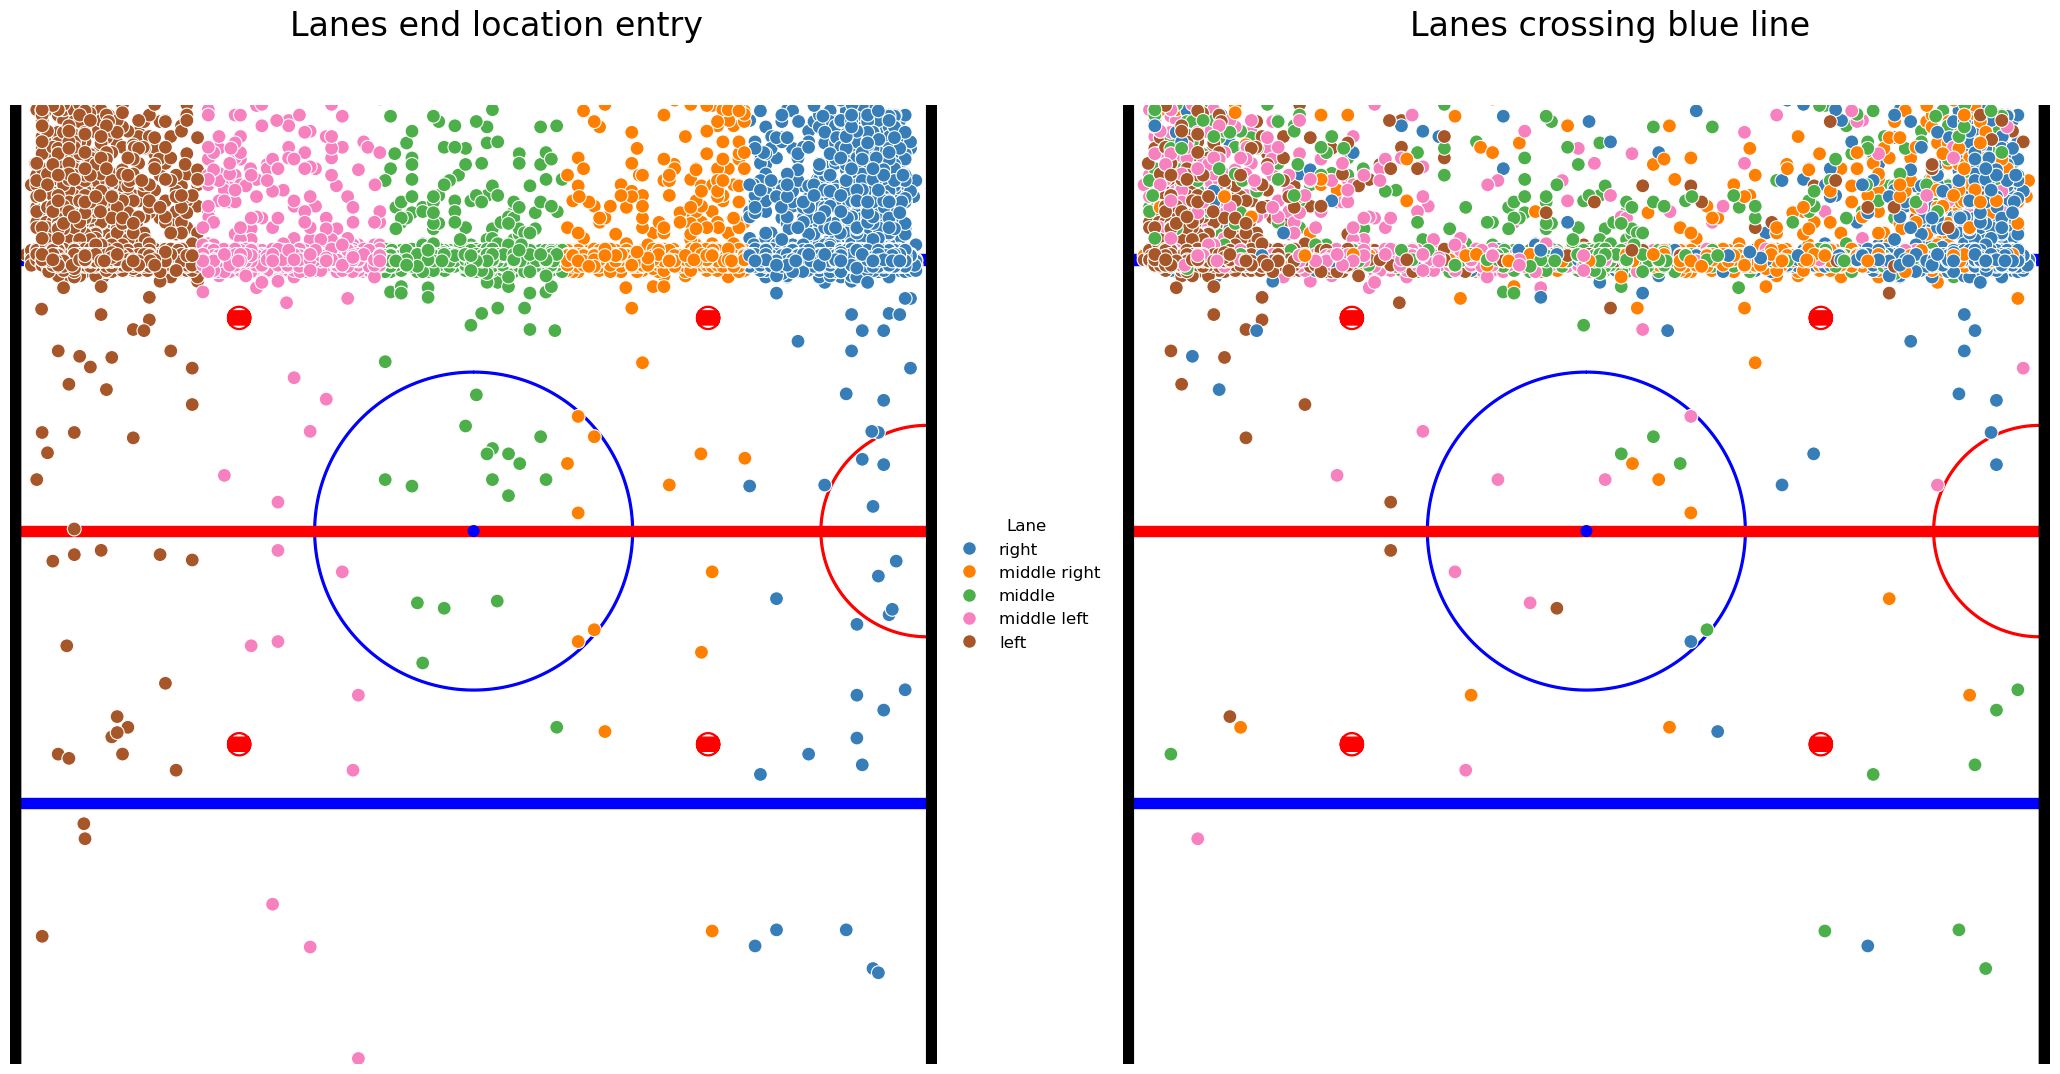

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 18))

rink = NHLRink(rotation=90, net={"visible": False})
rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=True, data=df_pre_entry[df_pre_entry['eventname'] == "controlledentry"], ax=axs[0], hue='entry_lane', draw_kw={"xlim": (-50.0, 40.0)}, palette=CB_color_cycle[0:5])

rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_pre_entry[df_pre_entry['eventname'] == "controlledentry"], ax=axs[1], hue='entry_lane_int', draw_kw={"xlim": (-50.0, 40.0)}, palette=CB_color_cycle[:5])
#fig.savefig('figs/sequence_exit_lanes.png',bbox_inches='tight')
fig.text(0.3,0.8,'Lanes end location entry', fontweight='regular',fontsize=24)
fig.text(1,0.8,'Lanes crossing blue line', fontweight='regular',fontsize=24)


axs[0].legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True, title="Exit Lane", title_fontsize=10, fontsize=10)
legend_elements = [
        lines.Line2D([0], [0], marker='o', color='w', label='right', markerfacecolor=CB_color_cycle[0], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle right', markerfacecolor=CB_color_cycle[1], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle', markerfacecolor=CB_color_cycle[2], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle left', markerfacecolor=CB_color_cycle[3], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='left', markerfacecolor=CB_color_cycle[4], markersize=10),
       ]
legend = axs[0].legend(handles=legend_elements, loc="center left",bbox_to_anchor=(1, 0.5), fontsize=12, prop={'size': 12}, ncol=1, title="Lane", title_fontsize=12)
frame = legend.get_frame()
frame.set_color('white')

plt.subplots_adjust(right=1.4)
plt.show()

fig.savefig('figs/sequence_entry_lanes.png',bbox_inches='tight')


In [23]:
df_pre_entry.loc[~df_pre_entry['xadjcoord_end'].isna(),'eventname'].value_counts()

eventname
pass               27417
controlledentry    11851
carry              10541
Name: count, dtype: int64

In [24]:
df_rank_entry_seq = df_pre_entry[['entry_seq','xT','entry_lane']].groupby('entry_seq').agg({'xT': 'sum', 'entry_lane': 'mean'}).reset_index()
df_rank_entry_seq.shape

(26921, 3)

In [25]:
df_rank_entry_int_seq = df_pre_entry[['entry_seq','xT', 'entry_lane_int']].groupby('entry_seq').agg({'xT': 'sum', 'entry_lane_int': 'mean'}).reset_index()
df_rank_entry_int_seq = df_rank_entry_int_seq.dropna()

In [26]:
df_rank_entry_seq = df_rank_entry_seq.dropna()

In [27]:
df_rank_entry_seq['entry_lane_name'] = df_rank_entry_seq['entry_lane'].map(entry_lanes)
df_rank_entry_int_seq['entry_lane_name_int'] = df_rank_entry_int_seq['entry_lane_int'].map(entry_lanes)

In [28]:
df_rank_entry_seq.sort_values('xT', ascending=False).head(20)

,entry_seq,xT,entry_lane,entry_lane_name
26597,99853,0.164154,3.0,middle left
24034,90410,0.158117,4.0,left
16124,60308,0.100323,4.0,left
21629,80958,0.095960,4.0,left
10390,38536,0.095867,0.0,right
24459,91929,0.094987,1.0,middle right
1880,7019,0.093311,3.0,middle left
5998,22258,0.090144,3.0,middle left
8120,30053,0.088106,1.0,middle right
13411,50037,0.088071,4.0,left


In [29]:
df_rank_entry_lane = df_rank_entry_seq.groupby('entry_lane_name').agg({'xT': 'mean'}).reset_index()
df_rank_entry_int_lane = df_rank_entry_int_seq.groupby('entry_lane_name_int').agg({'xT': 'mean'}).reset_index()

In [30]:
df_rank_entry_lane.sort_values('xT', ascending=False)

,entry_lane_name,xT
2,middle left,0.002227
1,middle,0.001814
3,middle right,0.001805
0,left,0.001723
4,right,0.001315


In [31]:
df_rank_entry_seq_plot = df_rank_entry_int_seq.sort_values('entry_lane_int', ascending=False)

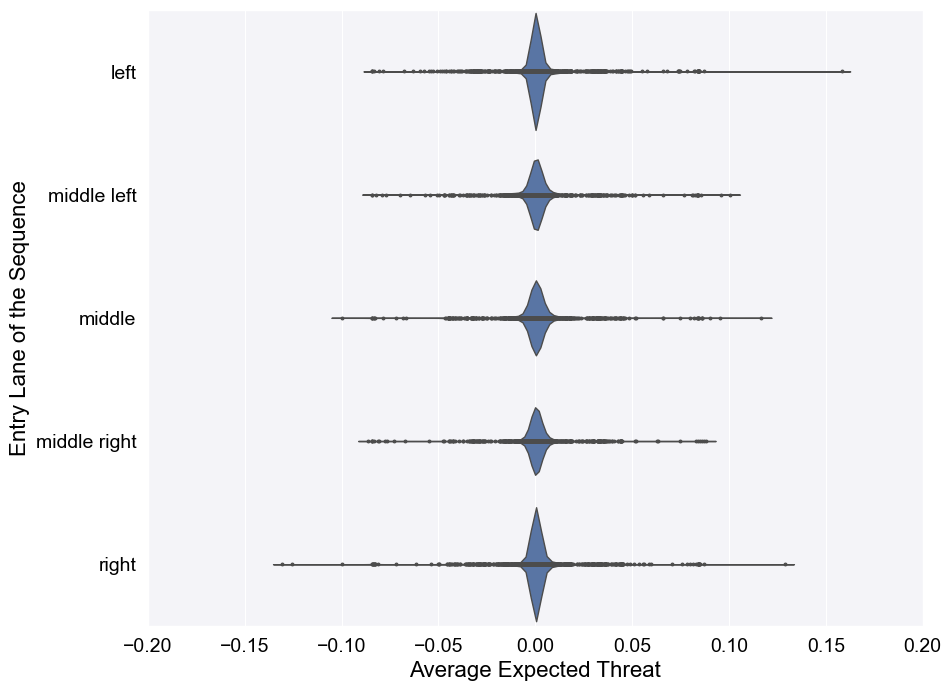

In [86]:
fig, ax = plt.subplots(figsize=(10,8))

text_color = "black"
background = "white"
edge = "white"

sns.set_theme(style="darkgrid")
sns.set_context("paper")

fig.set_facecolor(background)
ax.patch.set_alpha(0.5)

ax.set_xlim(-0.2, 0.2)

sns.violinplot(x=df_rank_entry_seq_plot["xT"].round(5), y=df_rank_entry_seq_plot["entry_lane_name_int"], orient='h', inner='point', density_norm='count', width=0.95)
ax.set_xlabel('Average Expected Threat' ,fontsize=16,color=text_color)
ax.set_ylabel('Entry Lane of the Sequence',fontsize=16,color=text_color)

ax.tick_params(axis='x', colors=text_color, labelsize=14)
ax.tick_params(axis='y', colors=text_color, labelsize=14)

plt.show()

fig.savefig('figs/net_expected_threat_entry_lanes',bbox_inches='tight')

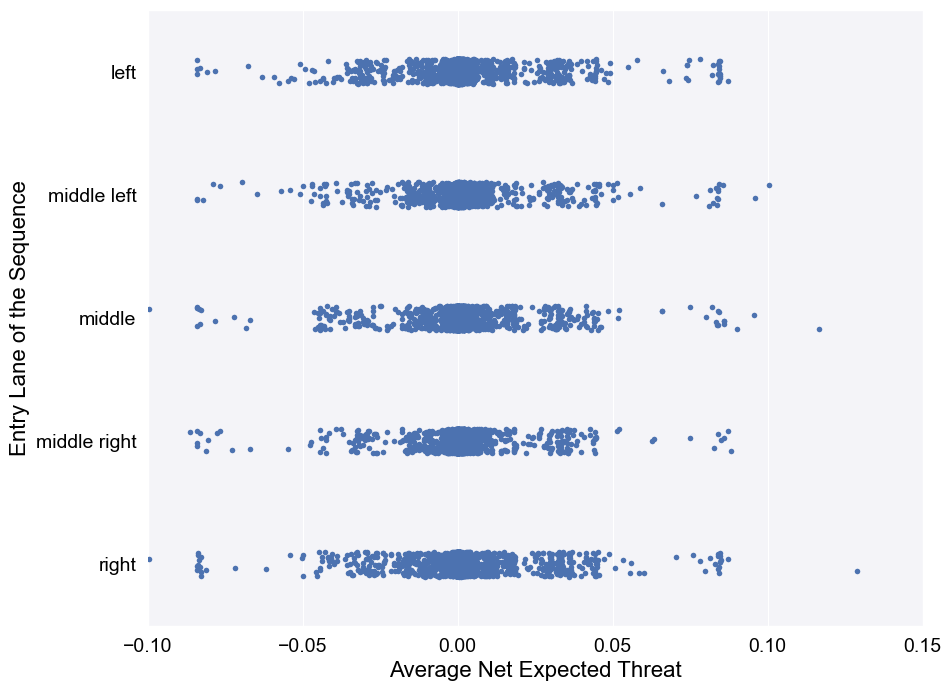

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

text_color = "black"
background = "white"

sns.set_theme(style="darkgrid")
sns.set_context("paper")

fig.set_facecolor(background)
ax.patch.set_alpha(0.5)

ax.set_xlim(-0.1, 0.15)

sns.stripplot(x=df_rank_entry_seq_plot["xT"].round(5), y=df_rank_entry_seq_plot["entry_lane_name_int"], orient='h', size=4, ax=ax)
ax.set_xlabel('Average Net Expected Threat', fontsize=16, color=text_color)
ax.set_ylabel('Entry Lane of the Sequence', fontsize=16, color=text_color)

ax.tick_params(axis='x', colors=text_color, labelsize=14)
ax.tick_params(axis='y', colors=text_color, labelsize=14)

plt.show()

/var/folders/fh/7p9x8r7s26n72fzxk8b2rs500000gn/T/ipykernel_8220/3519553408.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="entry_lane_name_int", y="xT", data=df_rank_entry_seq_plot, ax=ax, estimator=np.mean, ci=None)


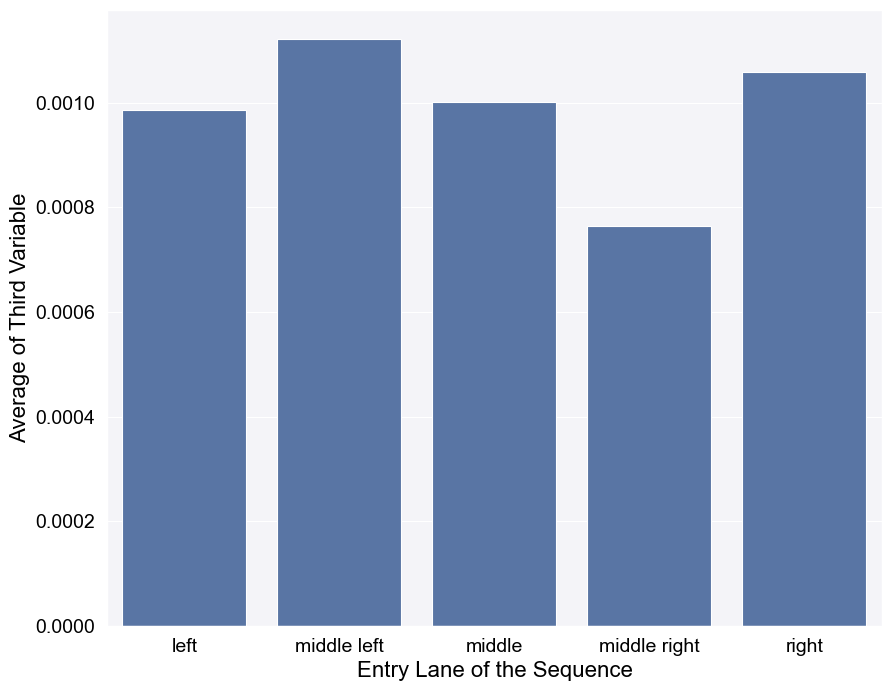

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

text_color = "black"
background = "white"

sns.set_theme(style="darkgrid")
sns.set_context("paper")

fig.set_facecolor(background)
ax.patch.set_alpha(0.5)

# Assuming df_rank_entry_seq_plot["third_variable"] is the variable you want to aggregate and visualize using a bar plot
# You can change the aggregation function based on your requirement, e.g., np.mean, np.sum, etc.
sns.barplot(x="entry_lane_name_int", y="xT", data=df_rank_entry_seq_plot, ax=ax, estimator=np.mean, ci=None)

ax.set_xlabel('Entry Lane of the Sequence', fontsize=16, color=text_color)
ax.set_ylabel('Average of Third Variable', fontsize=16, color=text_color)

ax.tick_params(axis='x', colors=text_color, labelsize=14)
ax.tick_params(axis='y', colors=text_color, labelsize=14)

plt.show()


In [35]:
df_pre_entry.head(100)

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg_allattempts,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal,next_event,interruption,next_teamid,next_teaminpossession,prev_event,xadjcoord_end,yadjcoord_end,xT_off,xT_def,xT,entry_seq,entry_seq_team,entry_in_seq,entry_intersection,x_exit,y_exit,entry_lane_int,entry_lane,entry_lane_name,entry_lane_name_int
6,72393,172367.0,814,706220,553243.0,885,885.0,0.0,NaN,4.466667,pass,0,evenStrength,5,failed,1,D,0,5,north,-7.338295,26.398914,6,0,0.0,0.0,1.0,0.0,0.0,0.0,block,0,814,885.0,reception,-1.813835,24.897058,-6.490208e-06,-0.000027,-0.000033,2,885.0,0,"(25.428571429999998, 17.49105520686405)",25.428571,17.491055,3.0,NaN,NaN,middle left
10,72393,553243.0,885,213380,172367.0,814,814.0,1.0,NaN,8.500000,carry,1,evenStrength,5,successful,1,F,0,5,none,-0.700874,-38.979412,10,1,0.0,0.0,0.0,0.0,0.0,0.0,puckprotection,0,814,814.0,puckprotection,8.855011,-40.991177,1.615000e-04,0.000016,0.000178,3,814.0,0,"(25.428571429999998, -44.480345832072544)",25.428571,-44.480346,NaN,NaN,NaN,NaN
19,72393,553243.0,885,213380,172367.0,814,NaN,NaN,NaN,12.433333,controlledentry,1,evenStrength,5,successful,1,F,0,5,carry,25.955009,-36.967648,19,1,0.0,0.0,0.0,0.0,0.0,0.0,puckprotection,0,814,814.0,carry,39.031479,-38.979412,NaN,NaN,NaN,3,814.0,0,"(25.42857143, -36.88665708626725)",25.428571,-36.886657,NaN,0.0,right,right
23,72393,172367.0,814,435025,553243.0,885,885.0,3.0,NaN,15.000000,carry,0,evenStrength,5,successful,1,F,0,5,none,-25.947121,40.481266,23,1,1.0,0.0,0.0,0.0,0.0,0.0,controlledexit,0,885,NaN,lpr,-0.800056,37.966560,-4.332828e-06,-0.000082,-0.000087,4,814.0,0,"(25.428571429999998, 35.34369837077066)",25.428571,35.343698,4.0,NaN,NaN,left
54,72393,553243.0,885,172367,172367.0,814,814.0,10.0,NaN,47.766666,pass,1,evenStrength,5,successful,1,G,0,5,d2d,-96.770531,4.280499,54,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,814,814.0,lpr,-94.255821,9.309910,-6.276129e-07,-0.000488,-0.000489,14,885.0,0,"(25.428571429999998, 248.67833202529727)",25.428571,248.678332,NaN,NaN,NaN,NaN
56,72393,553243.0,885,551549,172367.0,814,814.0,10.0,NaN,50.233334,pass,1,evenStrength,5,successful,1,D,0,5,outlet,-91.238174,23.392258,56,1,0.0,0.0,1.0,0.0,0.0,0.0,block,0,885,814.0,reception,-12.276413,-40.481266,2.605001e-04,0.000125,0.000385,15,814.0,0,"(25.428571429999998, -70.98147485410934)",25.428571,-70.981475,NaN,NaN,NaN,NaN
60,72393,553243.0,885,155992,172367.0,814,814.0,10.0,NaN,51.800000,pass,1,evenStrength,5,failed,1,F,0,5,north,-12.276413,-40.481266,60,0,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,814,814.0,controlledexit,1.303001,-10.304798,-2.631451e-04,-0.000022,-0.000285,15,814.0,0,"(25.42857143, 43.307564649096605)",25.428571,43.307565,NaN,NaN,NaN,NaN
70,72393,172367.0,814,710249,553243.0,885,NaN,NaN,NaN,59.133335,controlledentry,0,evenStrength,5,successful,1,F,0,5,pass,34.905602,-24.894119,70,1,0.0,0.0,0.0,0.0,0.0,0.0,shot,0,885,885.0,reception,64.574402,-28.917648,NaN,NaN,NaN,17,885.0,0,"(25.428571429999998, -23.608893524842692)",25.428571,-23.608894,NaN,1.0,middle right,middle right
108,72393,553243.0,885,376368,172367.0,814,814.0,19.0,NaN,92.333336,carry,1,shortHanded,5,successful,1,F,0,4,none,-25.855789,25.402954,108,1,1.0,0.0,0.0,0.0,0.0,0.0,controlledexit,0,814,NaN,lpr,-0.205795,29.426483,3.699457e-06,0.000650,0.000654,24,814.0,0,"(25.42857143, 33.44756088456503)",25.428571,33.447561,4.0,NaN,NaN,left
110,72393,553243.0,885,376368,172367.0,814,814.0,19.0,NaN,93.333336,carry,1,shortHanded,5,successful,1,F,0,4,none,-0.205795,29.426483,110,1,0.0,0.0,0.0,0.0,0.0,0.0,carry,0,814,814.0,controlledexit,25.947151,34.958832,2.587814e-04,-0.000167,0.000092,24,814.0,0,"(25.42857143, 34.849132331388304)",25.428571,34.849132,4.0,NaN,NaN,left


In [36]:
df_plot_entry = df_pre_entry[df_pre_entry['entry_seq'] == 24]
df_plot_entry_move = df_plot_entry[df_plot_entry['eventname'] != 'controlledentry']
df_plot_entry_point = df_plot_entry[df_plot_entry['eventname'] == 'controlledentry']

In [37]:
df_plot_entry[['eventname','xadjcoord', 'yadjcoord', 'xadjcoord_end', 'yadjcoord_end']]


,eventname,xadjcoord,yadjcoord,xadjcoord_end,yadjcoord_end
108,carry,-25.855789,25.402954,-0.205795,29.426483
110,carry,-0.205795,29.426483,25.947151,34.958832
113,controlledentry,25.947151,34.958832,51.094208,29.929420


In [39]:
plot_entry_lane_int = df_rank_entry_int_seq.loc[df_rank_entry_int_seq['entry_seq'] == 24, 'entry_lane_name_int'].values[0]
plot_xT_net = df_rank_entry_int_seq.loc[df_rank_entry_int_seq['entry_seq'] == 24, 'xT'].values[0]
plot_entry_lane_loc = df_rank_entry_seq.loc[df_rank_entry_seq['entry_seq'] == 24, 'entry_lane_name'].values[0]
plot_entry_lane_int, plot_entry_lane_loc, plot_xT_net

('left', 'left', 0.000745245466087081)

In [42]:
df_rank_entry_seq[df_rank_entry_seq['entry_seq'] == 24]

,entry_seq,xT,entry_lane,entry_lane_name
6,24,0.000745,4.0,left


In [43]:
df_rank_entry_seq.loc[df_rank_entry_seq['entry_seq'] == 24]

,entry_seq,xT,entry_lane,entry_lane_name
6,24,0.000745,4.0,left


In [44]:
df_plot_entry_point

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg_allattempts,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal,next_event,interruption,next_teamid,next_teaminpossession,prev_event,xadjcoord_end,yadjcoord_end,xT_off,xT_def,xT,entry_seq,entry_seq_team,entry_in_seq,entry_intersection,x_exit,y_exit,entry_lane_int,entry_lane,entry_lane_name,entry_lane_name_int
113,72393,553243.0,885,376368,172367.0,814,NaN,NaN,NaN,94.433334,controlledentry,1,shortHanded,5,successful,1,F,0,4,carrywithplaywithshotonnetandslotshot,25.947151,34.958832,113,1,0.0,0.0,0.0,0.0,0.0,0.0,pass,0,814,814.0,controlledentryagainst,51.094208,29.92942,NaN,NaN,NaN,24,814.0,0,"(25.42857143, 35.062547737925804)",25.428571,35.062548,4.0,4.0,left,left


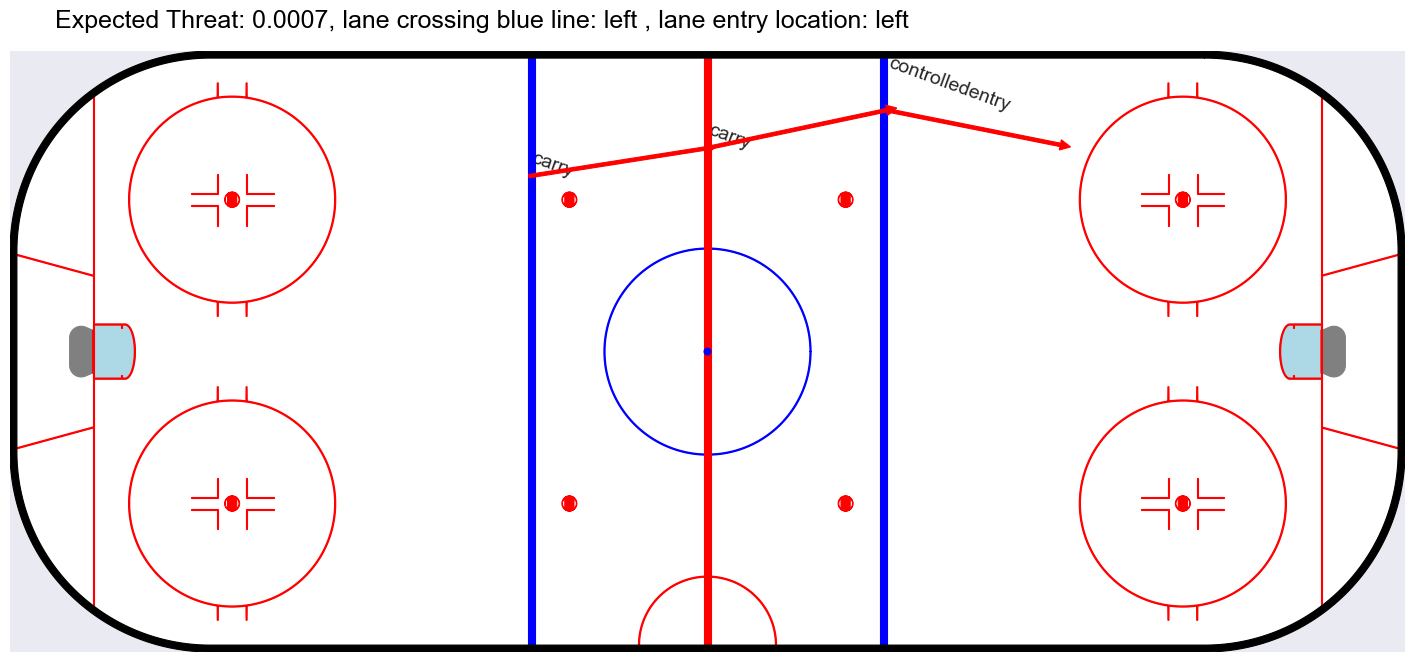

In [82]:
rink = NHLRink()

fig, ax = plt.subplots(figsize=(18, 8))

text_color = "black"
background = "white"
edge = "white"
sns.set_context("paper")
fig.text(0.15,0.9,'Expected Threat: {}, lane crossing blue line: {} , lane entry location: {}'.format(round(plot_xT_net,4), plot_entry_lane_int, plot_entry_lane_loc), fontweight='regular',fontsize=18,color=text_color)


rink.arrow(data=df_plot_entry, x='xadjcoord', y='yadjcoord', x2='xadjcoord_end', y2='yadjcoord_end', ax=ax, color='red', width=0.5, head_width=1.5, head_length=1.5)
#rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_plot_exit[df_plot_exit['eventname'] == 'controlledexit'], ax=ax)

for i,row in df_plot_entry.iterrows():
    ax.annotate(row['eventname'], xy=(row['xadjcoord'], row['yadjcoord']), size=14, rotation=-20)

plt.show()

fig.savefig('figs/example_entry_seq',bbox_inches='tight')

# Analysis of exit passes and carries

In [46]:
df_carry['is_entry'].value_counts()

is_entry
0.0    25475
1.0     8439
Name: count, dtype: int64

In [47]:
df_passes['is_entry'].value_counts()

is_entry
0.0    128283
1.0       692
Name: count, dtype: int64

In [48]:
df_entry_carries = df_carry[(df_carry['is_entry'] == 1) & (df_carry['outcome_code'] == 1)].copy()
df_entry_passes = df_passes[(df_passes['is_entry'] == 1) & (df_passes['outcome_code'] == 1)].copy()

In [49]:
df_entry_carries.shape, df_entry_passes.shape

((8439, 44), (66, 44))

In [50]:
df_entry_carries['entry_intersection'] = df_entry_carries.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_entry_carries['x_entry'] = df_entry_carries['entry_intersection'].str[0]
df_entry_carries['y_entry'] = df_entry_carries['entry_intersection'].str[1]

In [51]:
df_entry_passes['entry_intersection'] = df_entry_passes.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_entry_passes['x_entry'] = df_entry_passes['entry_intersection'].str[0]
df_entry_passes['y_entry'] = df_entry_passes['entry_intersection'].str[1]

In [52]:
df_entry_carries["entry_lane_int"] = pd.cut(df_entry_carries['y_entry'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)
df_entry_passes["entry_lane_int"] = pd.cut(df_entry_passes['y_entry'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)


In [53]:
df_entry_passes["entry_lane"] = pd.cut(df_entry_passes["yadjcoord_end"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)
df_entry_carries["entry_lane"] = pd.cut(df_entry_carries["yadjcoord_end"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [54]:
df_entry_carries['entry_lane'].value_counts()

entry_lane
4    1800
0    1758
1    1657
2    1634
3    1590
Name: count, dtype: int64

In [55]:
df_entry_carries['entry_lane_int'].value_counts()

entry_lane_int
4.0    2765
0.0    2518
2.0    1055
3.0    1041
1.0    1024
Name: count, dtype: int64

In [56]:
df_entry_passes['entry_lane'].value_counts()

entry_lane
4    27
0    26
2     5
1     5
3     3
Name: count, dtype: int64

In [57]:
df_entry_passes['entry_lane_int'].value_counts()

entry_lane_int
4    24
0    19
2    11
1     7
3     5
Name: count, dtype: int64

In [78]:
df_entry_passes[['xT_off', 'xT_def','xT', 'entry_lane']].groupby('entry_lane').mean().sort_values('xT', ascending=False)

,xT_off,xT_def,xT
entry_lane,,,
2,0.002323,0.000181,0.002503
3,0.001437,0.000055,0.001492
1,0.001578,-0.000486,0.001092
0,0.000345,-0.000013,0.000332
4,0.000167,-0.000119,0.000048


In [93]:
df_entry_passes[['xT', 'entry_lane']].groupby('entry_lane').mean().sort_values('xT', ascending=False)

,xT
entry_lane,
2,0.002503
3,0.001492
1,0.001092
0,0.000332
4,0.000048


In [94]:
df_entry_carries[['xT', 'entry_lane']].groupby('entry_lane').mean().sort_values('xT', ascending=False)

,xT
entry_lane,
0,-0.000411
4,-0.000466
3,-0.001649
1,-0.002539
2,-0.009637


In [90]:
df_entry_carries[['xT_off', 'xT_def','xT', 'entry_lane_int']].groupby('entry_lane_int').mean().sort_values('xT', ascending=True)

,xT_off,xT_def,xT
entry_lane_int,,,
2.0,0.000323,-0.005290,-0.004966
3.0,0.000029,-0.004115,-0.004086
1.0,0.000457,-0.003359,-0.002902
4.0,0.000117,-0.002427,-0.002310
0.0,0.000222,-0.002278,-0.002056
